Parte 3
===

In [172]:
import warnings as ws
ws.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:,.2f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

## 1. Carga de la base de datos

In [155]:
df = pd.read_csv('data/result.csv', sep=";", encoding='utf-8')

df.shape

(39985, 12)

In [156]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Creditos,"39,985.00",1.76,1.28,1.00,1.00,1.00,2.00,26.00
saldo_actual,"39,985.00","34,570,607.56","74,068,491.07","4,500,000.00","7,749,000.00","16,436,000.00","38,852,000.00","6,082,201,976.00"
saldo_vencido,"39,985.00","3,878,851.64","18,333,550.42",0.00,0.00,0.00,"96,000.00","1,608,429,952.00"
Promedio de limite_credito,"39,985.00","1,268,096.11","3,877,582.26",0.00,0.00,0.00,0.00,"101,900,000.00"
Promedio de credito_maximo,"39,985.00","16,868,726.57","21,271,197.05",0.00,"6,000,000.00","10,878,000.00","21,100,000.00","835,961,274.91"
Promedio de cantidad_cuotas,"39,985.00",55.65,43.31,0.00,25.00,57.00,72.00,592.00
Promedio de valor_cuota,"39,985.00","1,822,626.15","6,433,925.02",0.00,"248,000.00","406,333.33","800,000.00","339,129,984.00"
Comunicaciones_saldo_actual,"39,985.00",163.76,"32,746.14",0.00,0.00,0.00,0.00,"6,548,000.00"
%_comunicaciones,"39,985.00",0.00,0.00,0.00,0.00,0.00,0.00,0.17
Consumo_saldo_actual,"39,985.00","21,356,587.77","44,665,566.23",0.00,"5,363,000.00","10,389,000.00","24,377,000.00","3,776,354,064.00"


Luego de un pequeño análisis exploratorio, concluímos que estas variables son propicias para realizar la segmentación de usuarios. 

## 2. Segmentación de usuarios

Para realizar la segmentación de usuarios tenemos diferentes posibilidades de metodologías. Para efecto de este trabajo usaremos únicamente **KMeans** y realizaremos un ajuste basado en el **método del codo** para seleccionar una cantidad de grupos o segmentos apropiados para el problema.

In [157]:
# Eliminamos la variable objetivo ya que no aporta en la segmentación
group_df = df.copy()
# group_df = df[df.outlier == 0].copy().drop(columns='outlier')
# group_high_df = df[df.outlier == 1].copy().drop(columns='outlier')
# group_high_df['cluster'] = -1

# Dejemos escalados los datos para el modelado de Clustering
# scaler, columns = MinMaxScaler(), group_df.columns
# group_scaled_df = pd.DataFrame(scaler.fit_transform(group_df), columns=columns)

# group_high_df.shape, group_df.shape, group_scaled_df.shape
group_df.shape #, group_scaled_df.shape

(39985, 12)

### Selección cantidad de segmentos

Vamos a ejecutar el método KMeans de forma iterativa para diferentes tamaños de cluster, desde 1 hasta 9. Luego, vamos a graficar y validar en que cantidad de cluster se comporta mejor.

In [170]:
def run_clustering_range(X, lower=1, upper=10):
    distortions = []
    range_ = range(lower, upper)
    for k in range_:
        model = KMeans(n_clusters=k, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)
    return distortions, range_

def show_clustering_elbow(distortions, range_):
    plt.figure(figsize=(12, 8))
    plt.plot(range_, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

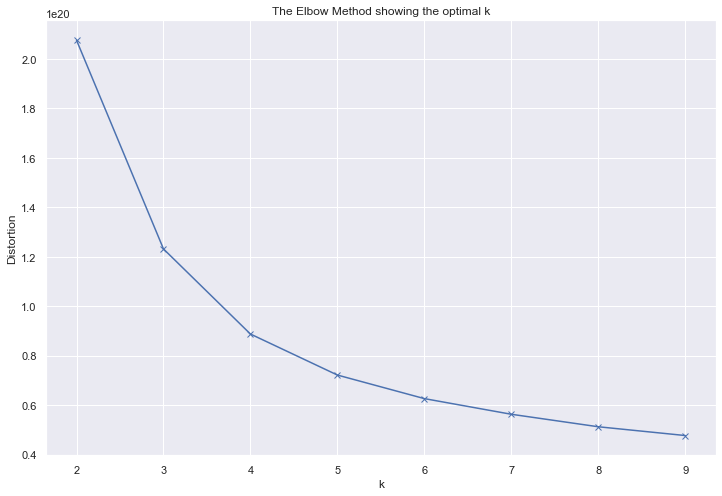

In [171]:
distortions, range_ = run_clustering_range(group_df, 2, 10)
show_clustering_elbow(distortions, range_)

Notese que el codo más pronunciado esta en 3 clusters, pero se presenta un debate entre usar 3 o 4 clusters. Vamos a decidir usando las métricas de evaluación **Silhouette Coefficient**.

In [180]:
for k in [3, 4]:
    model_ = KMeans(n_clusters=k, random_state=0).fit(group_df)
    print(f"Entrenamiento completado para {k} clusters")
    print(f"Silhouette coefficient para {k} clusters: {silhouette_score(group_df, model_.labels_, metric='euclidean')}")

Entrenamiento completado para 3 clusters
Silhouette coefficient para 3 clusters: 0.7698794472902841
Entrenamiento completado para 4 clusters
Silhouette coefficient para 4 clusters: 0.6528886403473082


Dado el resultado anterior la cantidad correcta de clusters es **3**.

In [181]:
model_final = KMeans(n_clusters=3, random_state=0)
model_final.fit(group_df)

pd.Series(model_final.labels_).value_counts()

0    37557
1     2424
2        4
dtype: int64

Notese que tenemos un cluster con 4 usuarios. Vamos a evaluar los datos de este cluster y graficar todos los clusters juntos para visualizar separación de los grupos.

### Evaluación del modelo seleccionado

In [184]:
grouped_df = group_df.copy()
grouped_df['cluster'] = model_final.labels_

# grouped_scaled_df = group_scaled_df.copy()
# grouped_scaled_df['cluster'] = model_final.labels_

<AxesSubplot:title={'center':'Flattened Graph of KMeans(n_clusters=3, random_state=0) model'}>

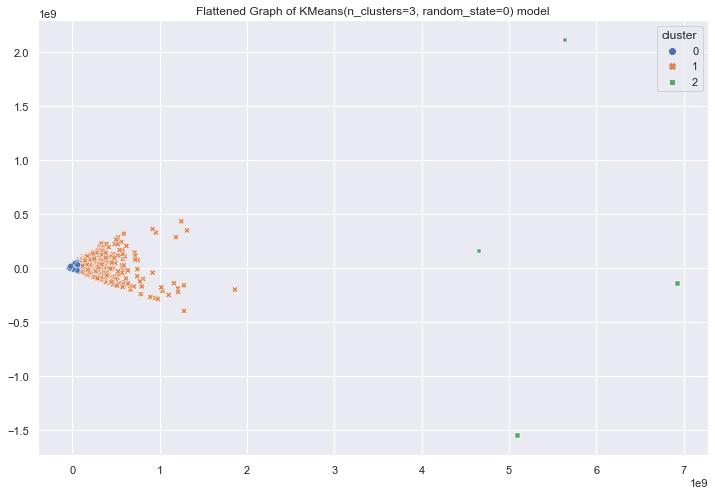

In [186]:
transformed = PCA(n_components=2, random_state=1).fit_transform(grouped_df)

plt.figure(figsize=(12, 8))
plt.title(f'Flattened Graph of {str(model_final)} model')
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=grouped_df.cluster, 
                style=grouped_df.cluster, palette='deep')

Visualmente podemos notar que el **cluster 2** presenta unos datos bastante alejados de los otros grupos. Visualizamos nuevamente pero los otros dos cluster.

<AxesSubplot:title={'center':'Flattened Graph of KMeans(n_clusters=3, random_state=0) model'}>

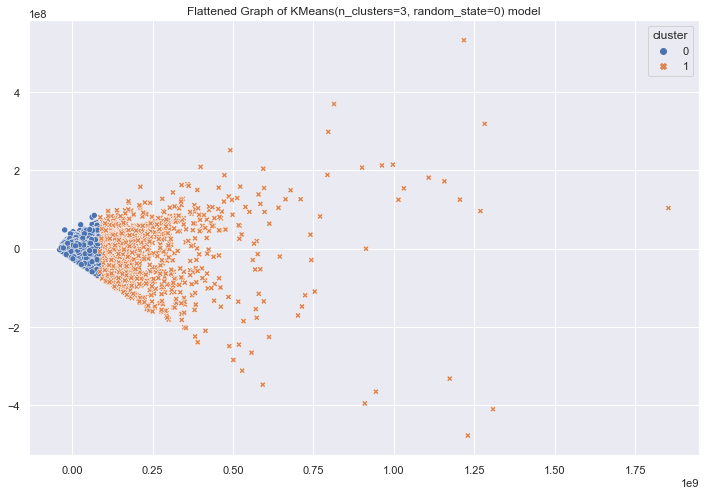

In [188]:
temp_grouped_df = grouped_df[grouped_df.cluster != 2]

transformed_ = PCA(n_components=2, random_state=1).fit_transform(temp_grouped_df)

plt.figure(figsize=(12, 8))
plt.title(f'Flattened Graph of {str(model_final)} model')
sns.scatterplot(x=transformed_[:,0], y=transformed_[:,1], hue=temp_grouped_df.cluster, 
                style=temp_grouped_df.cluster, palette='deep')

En esta gráfica podemos notar bien definidos el **cluster 0 y 1**. Vamos a analizar un poco la composición de cada cluster en términos de los datos para etiquetarlos y poder definir estrategías.

Lo primero que haremos es separar el **cluster 2** de todo el conjunto, no sin antes determinar una etiqueta correcta para este grupo de usuarios, que sirva para plantear estrategías de comunicación.

In [198]:
grouped_df[grouped_df.cluster == 2].transpose()

,10002,12198,20948,21695
Creditos,11.00,8.00,11.00,20.00
saldo_actual,"5,791,003,096.00","3,808,950,064.00","6,082,201,976.00","4,264,518,048.00"
saldo_vencido,"1,608,429,952.00",0.00,0.00,0.00
Promedio de limite_credito,0.00,"4,476,250.00","22,000,000.00","80,000,000.00"
Promedio de credito_maximo,"835,961,274.91","471,296,008.00","828,251,895.20","303,669,210.95"
Promedio de cantidad_cuotas,58.00,17.00,92.00,52.00
Promedio de valor_cuota,"100,060,364.91","72,885,876.00","20,274,272.73","8,126,550.00"
Comunicaciones_saldo_actual,0.00,0.00,0.00,0.00
%_comunicaciones,0.00,0.00,0.00,0.00
Consumo_saldo_actual,"921,582,976.00","3,776,354,064.00","3,367,578,864.00","2,060,174,000.00"


In [200]:
grouped_df[grouped_df.cluster == 2].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Creditos,4.00,12.50,5.20,8.00,10.25,11.00,13.25,20.00
saldo_actual,4.00,"4,986,668,296.00","1,118,878,862.85","3,808,950,064.00","4,150,626,052.00","5,027,760,572.00","5,863,802,816.00","6,082,201,976.00"
saldo_vencido,4.00,"402,107,488.00","804,214,976.00",0.00,0.00,0.00,"402,107,488.00","1,608,429,952.00"
Promedio de limite_credito,4.00,"26,619,062.50","36,831,774.60",0.00,"3,357,187.50","13,238,125.00","36,500,000.00","80,000,000.00"
Promedio de credito_maximo,4.00,"609,794,597.26","265,687,516.00","303,669,210.95","429,389,308.74","649,773,951.60","830,179,240.13","835,961,274.91"
Promedio de cantidad_cuotas,4.00,54.75,30.72,17.00,43.25,55.00,66.50,92.00
Promedio de valor_cuota,4.00,"50,336,765.91","43,460,152.20","8,126,550.00","17,237,342.05","46,580,074.36","79,679,498.23","100,060,364.91"
Comunicaciones_saldo_actual,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
%_comunicaciones,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Consumo_saldo_actual,4.00,"2,531,422,476.00","1,299,059,981.41","921,582,976.00","1,775,526,244.00","2,713,876,432.00","3,469,772,664.00","3,776,354,064.00"


Notese como en el **cluster 2** tenemos solo 4 usuarios. Estos tienen los valores más altos de **saldo_actual**, **saldo_vencido**, **Promedio de credito_maximo**, **Promedio de valor_cuota** y **Consumo_saldo_actual**. Esto significa que puede tratarse de grandes clientes empresariales que tienen valores de préstamos o servicios de grandes sumas de dinero.

La variable **Consumo_saldo_actual** esta relacionada con el producto **Crédito de Consumo**. Podemos notar como este valor incide muy fuerte sobre **saldo_actual**, es decir, la suma consolidada de todos los compromisos.

Vamos a etiquetar este cluster como: **Grandes Cuentas**.

In [201]:
grouped_df['cluster'] = grouped_df.cluster.apply(
    lambda x: 'Grandes Cuentas' if x == 2 else x
)

grouped_df.cluster.value_counts()

0                  37557
1                   2424
Grandes Cuentas        4
Name: cluster, dtype: int64

Ahora, continuemos el análisis pero únicamente con el **cluster 0 y 1**

In [202]:
grouped_temp_df = grouped_df[grouped_df.cluster.isin([0, 1])]
grouped_temp_df.cluster.value_counts()

0    37557
1     2424
Name: cluster, dtype: int64

In [206]:
aggregate_dict = dict(zip(grouped_temp_df.columns[:-1], [['count', 'min', 'mean', 'max'] for i in grouped_temp_df.columns[:-1]]))

grouped_temp_df.groupby('cluster').agg(aggregate_dict).transpose()

cluster                                        0                1
Creditos                    count      37,557.00         2,424.00
                            min             1.00             1.00
                            mean            1.60             4.22
                            max            10.00            26.00
saldo_actual                count      37,557.00         2,424.00
                            min     4,500,000.00    75,175,000.00
                            mean   24,247,026.76   186,350,448.10
                            max   141,206,000.00 1,597,282,024.00
saldo_vencido               count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean    3,110,934.47    15,119,672.87
                            max   280,646,000.00   865,009,024.00
Promedio de limite_credito  count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean    1,118,890.10     3,538,032.67
                            max    90,000,000.00   101,900,000.00
Promedio de credito_maximo  count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean   14,000,767.38    60,325,921.13
                            max   140,000,000.00   580,000,000.00
Promedio de cantidad_cuotas count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean           53.44            89.90
                            max           592.00           363.00
Promedio de valor_cuota     count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean    1,664,486.24     4,192,759.85
                            max   134,928,000.00   339,129,984.00
Comunicaciones_saldo_actual count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean          174.35             0.00
                            max     6,548,000.00             0.00
%_comunicaciones            count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean            0.00             0.00
                            max             0.17             0.00
Consumo_saldo_actual        count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean   15,518,711.37   107,665,523.54
                            max    91,493,000.00 1,067,885,024.00
%_consumo                   count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean            0.73             0.63
                            max             1.00             1.00
perfil_usuario_Sin registro count      37,557.00         2,424.00
                            min             0.00             0.00
                            mean            0.33             0.38
                            max             1.00             1.00

Analizando cada una de las variables, sus valores promedio, mínimo y máximo, podemos intuir que el **cluster 0** agrupa usuarios que tienen valores más pequeños en sus compromisos financieros. Por otro lado, los usuarios del **cluster 1** tienen valores intermedios. 

Las variables que más aportan a esta determinanción son: **Creditos, saldo_actual, saldo_vencido, Promedio de credito_maximo, Promedio de valor_cuota, Consumo_saldo_actual.** El resto no tienen tanta influencia.

Vamos a graficar estas variables y confirmar visualmente las suposiciones anteriores.

<AxesSubplot:xlabel='saldo_actual', ylabel='saldo_vencido'>

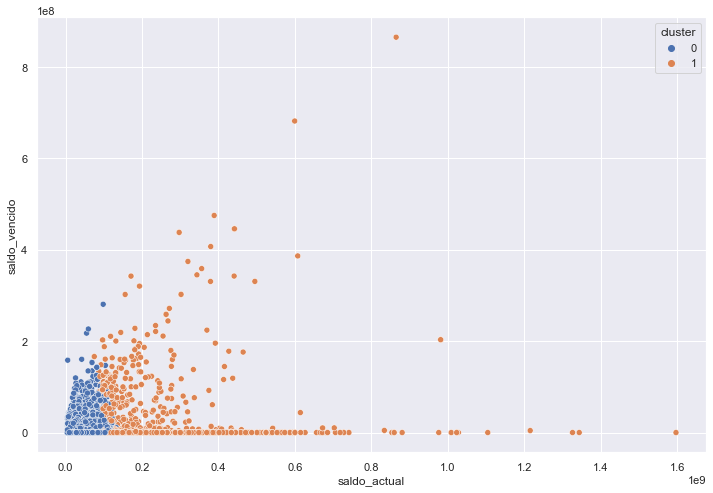

In [221]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="saldo_actual", y="saldo_vencido", hue="cluster")

<AxesSubplot:xlabel='saldo_actual', ylabel='Promedio de credito_maximo'>

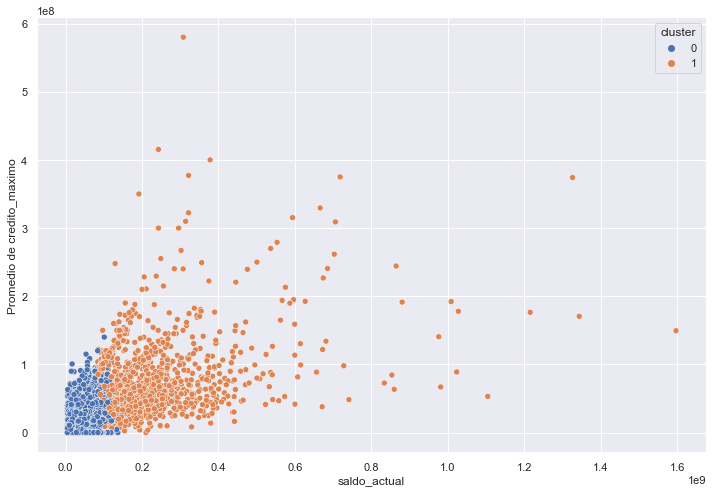

In [222]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="saldo_actual", y="Promedio de credito_maximo", hue="cluster")

<AxesSubplot:xlabel='saldo_actual', ylabel='Promedio de valor_cuota'>

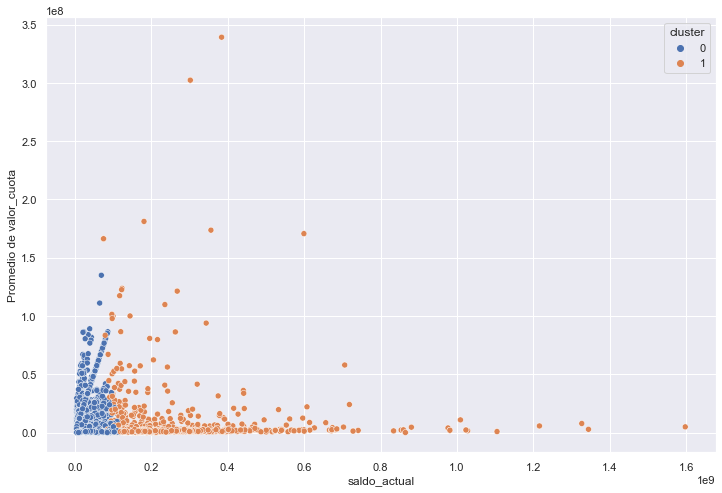

In [223]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="saldo_actual", y="Promedio de valor_cuota", hue="cluster")

<AxesSubplot:xlabel='saldo_actual', ylabel='Consumo_saldo_actual'>

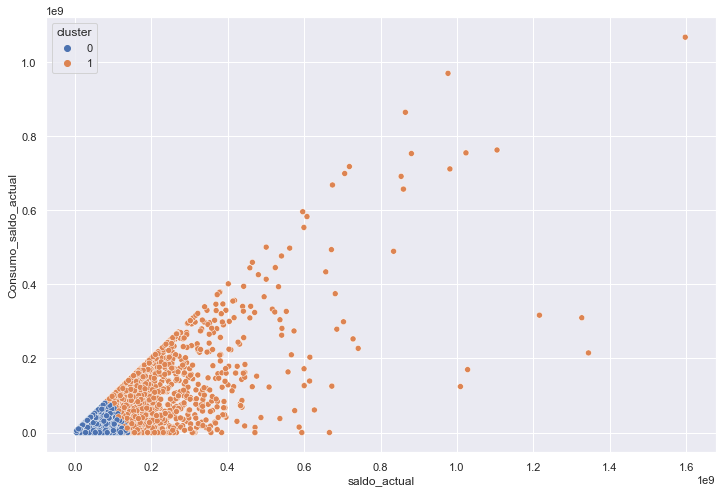

In [224]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="saldo_actual", y="Consumo_saldo_actual", hue="cluster")

<AxesSubplot:xlabel='Promedio de credito_maximo', ylabel='Consumo_saldo_actual'>

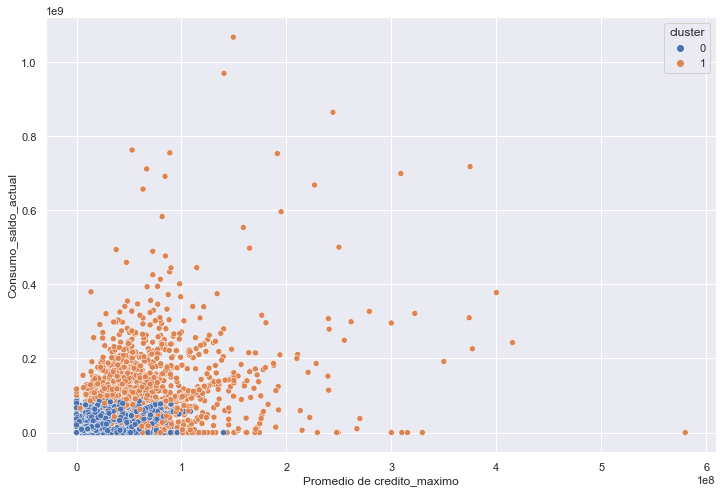

In [226]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="Promedio de credito_maximo", y="Consumo_saldo_actual", hue="cluster")

Las gráficas y resumenes anteriores nos permitir confirmar que el **cluster 0** hace referencia a usuarios con carteras más pequeñas. Puede tratarse de personas naturales con una cantidad baja de créditos (el valor promedio es 1.6). Vamos a clasificar este grupo con la etiquetas: **Cuentas Persona Natural**.

Por otro lado, el **cluster 1** tiene usuarios efectivamente con una cantidad de productos intermedia (valor promedio 4.22) y se puede notar visualmente, que los saldos y valores promedio de crédito máximo y valor cuota son más altos que el cluster 0. Se trata de personas que mueven más vólumen, quizás pequeñas empresas o independientes que realizan transacciones más grandes. Vamos a etiquetar este grupo como **Cuentas Pequeños Negocios**.

In [228]:
grouped_df['cluster'] = grouped_df.cluster.apply(
    lambda x: 'Cuentas Persona Natural' if x == 0 else x
)
grouped_df['cluster'] = grouped_df.cluster.apply(
    lambda x: 'Cuentas Pequeños Negocios' if x == 1 else x
)

grouped_df.cluster.value_counts()

Cuentas Persona Natural      37557
Cuentas Pequeños Negocios     2424
Grandes Cuentas                  4
Name: cluster, dtype: int64

## 3. Estrategías de marketing por segmento

**Cuentas Persona Natural**: 
> *Estimado (nombre del cliente). ¿Necesitas ponerte al día con tus pagos y aún no puedes? Recueda que tu bienestar financiero es importante para nosotros y podemos ayudarte a normalizar tus deudas, solo debes ingresar a este [enlace](enlace) y encontrarás más detalles*

**Cuentas Pequeños Negocios**: 
> *Estimado (nombre del cliente). ¿Has tenido dificultades para el pago de tus deudas? ¿Necesitas un salvavidas justo ahora? Tu bienestar es importante para nosotros  y podemos ayudarte a normalizar tus compromisos, solo debes ingresar a este [enlace](enlace) y encontrarás más detalles*

**Grandes Cuentas**: 
> *Estimado (nombre del cliente). ¿Necesitas algún tipo de alivio financiero en este momento? Eres uno de nuestros clientes VIP y tenemos un paquete de beneficios para normalizar tus deudas, solo debes ingresar a este [enlace](enlace) y encontrarás más detalles*